# Before putting on website change all "C:/Users/zeinab" to desire_path

# Testing multielectrode GEMsort algorithm using 16-channel synthesized data

In [1]:
from numpy import apply_along_axis as apply
from scipy.signal import fftconvolve
from scipy import signal
from GEMsort_func import GEMsort
from Smoothing_data import Smoothing_filter
from Cut_func import cut
from scipy.signal import butter, lfilter
from copy import deepcopy
from numpy.linalg import svd
from numpy.linalg import svd
from mpl_toolkits.mplot3d import Axes3D
import copy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import struct
import time
import numpy.matlib
import numpy.matlib


## Please choose one of the dataset in below cell (generated by data file in this repository)

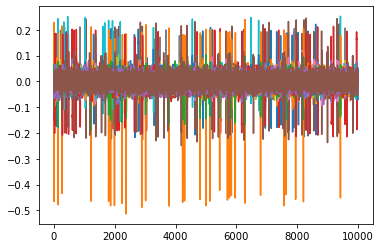

In [2]:
#loading and plotting the data
np.random.seed(10)
path = '/Users/zm6112/Dropbox (Princeton)/PHD_paper & material/new code_use this for postdoc analysis/website_all_codes/data/synthetic data'

# data=np.load(path + '/multi_16ch_usualdata.npy', allow_pickle=True)
data = np.load(path + '/multi_16ch_samecells.npy', allow_pickle=True) #this is the similar cells (for two cells)  dataset
# data=np.load(path + '/multi_16ch_sametime.npy', allow_pickle=True) #this is the same firing time (for two cells) dataset

X = data

%matplotlib inline
for i in range(16):
    plt.plot(X[i,:][0:10000])
plt.show()

### If you are running the data for same time firing cells or similar cells of channels i, j (i.e. multi_16ch_sametime or multi_16ch_samecells),please uncomment below cell to see the same time effect

In [3]:
################ for multi_16ch_sametime data or multi_16ch_samecells ############
# i=0
# j=3
# # Size = 10000 #if data is multi_16ch_sametime 
# Size = 1000 #if data is multi_16ch_samecells   


# plt.plot(X[i,:][0:Size], c='r')
# plt.plot(X[j,:][0:Size], c= 'b')
# plt.show()

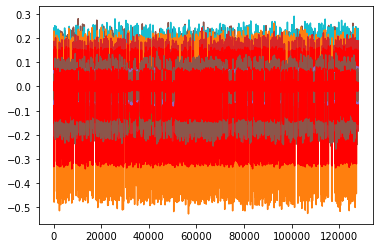

In [4]:
#Smoothing filter
#%matplotlib qt

for i in range(16):
    data_raw = X[i,:]
    plt.plot(data_raw)
    filtered_data = Smoothing_filter(data_raw, low=10, high=5000, sf=80000, order=2)
    plt.plot(filtered_data, c='r')
#     plt.show()
    
    X[i,:]=filtered_data

# plt.plot(data_raw[1:L,:])
# plt.plot(filtered_data[1:L,:],c='r')
# plt.show()

#short view
# for i in range(16):
#     plt.plot(X[i,:])
# plt.xlim([0,10000])
# plt.ylim([-0.3,0.3])
# plt.show()

# %matplotlib qt

# for i in range(16):
#     y=np.zeros((1,1000))+i+5
#     plt.plot(X[i,:][0:1000]+i) # +i is only for plotting figures with verrtical distace in one fig
#     plt.show()

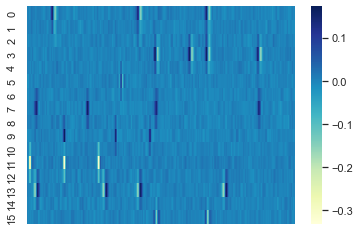

In [5]:
# plot heatmap 
np.random.seed(0)
sns.set_theme()
uniform_data = X[:, 0:2000]
# ax = sns.heatmap(uniform_data, cmap="YlGnBu", xticklabels=False)#, vmin=0.2, vmax=1) #cmap="Greens","BuPu","Blues"
# ax = sns.heatmap(uniform_data, cmap="YlGnBu", xticklabels=False, center=0)#, vmin=0.2, vmax=1)

uniform_data = X[:, 0:1000]
ax = sns.heatmap(uniform_data, cmap="YlGnBu", xticklabels=False)#, vmin=0.2, vmax=1)
# ax = sns.heatmap(uniform_data, cmap="YlGnBu", xticklabels=False, center=0)#, vmin=0.2, vmax=1)

In [6]:
############# main program for getting spikes of channels #####
start_time = time.time()

#stage 1: detecting peaks of all channels
T1 = 64
ch_num = 16
T = X.shape[1] #length of data
N = T
Tdis = 50

p_all = np.array([], dtype = object).reshape((1,0))
cut_ch = []

for k in range (ch_num): #to have seprate units to save i and j of similar groups
    cut_ch .append([])

for i in range (16): #for every channel
    #print(i)
    x = X[i,:] 
    sigma = np.median(np.abs(x)/0.6745)
    Tp = 4*sigma  
    p,_ = scipy.signal.find_peaks(x, height = Tp, distance = Tdis)#np.abs(x) 
    
    if i == 15:#chon in canal peak paien bozorg darad va bayad abs bedarim
        p,_ = scipy.signal.find_peaks(np.abs(x), height = Tp, distance = Tdis)
        
    for j in range(np.array(p).shape[0]):
         cut_ch[i].append(cut(x,p[j],T1)[0]) 
    
    if p == []:
        p = [0] #to prevent error, so in every row if p=0 means: no peak in that channel
    y_arr = np.array([], dtype = np.int32)
    y = p
    y_arr = np.append(y_arr,y)
    #print(y_arr)
    p_all = np.append(p_all, 0)
    #print(p_all)
    p_all[-1] = y_arr.astype(int) 
 
print("--- %s seconds ---" % (time.time() - start_time))


# %matplotlib inline
# for i in range(np.array(cut_ch).shape[1]):
#     plt.plot(np.array(cut_ch)[0,i,:])
# plt.show()       

# for i in range(np.array(cut_ch).shape[1]):
#     plt.plot(np.array(cut_ch)[0,i,:])
#     plt.show() 

--- 0.06872701644897461 seconds ---


/var/folders/ds/ptgs391j5r77g4x8rmgcj4mh0000gp/T/ipykernel_75018/1083559693.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if p == []:


In [7]:
# raster plot for cells' spikes
%matplotlib qt
path = '/Users/zm6112/desktop'
colors = ['dodgerblue', 'skyblue', 'gray','deeppink','orange','saddlebrown','lawngreen', 'g','black','cyan','red','brown','lightgray','yellow','pink','magenta']
main_cells_channels = [0, 3, 5, 7, 9, 11, 13, 15]
cells = range(1, 9)
length_signal = 20000 

fig = plt.figure(figsize=(10, 10), dpi=300)
ax = fig.add_subplot(1, 1, 1) 
ax.set_facecolor('xkcd:white')

print('p_all[i][0:length_signal].shape = ', p_all[i][0:length_signal].shape)
print('x.shape=', x.shape)
xticks = [0, 50, 100, 150, 200, 250, 300, 350, 400]
k = 0
for i in main_cells_channels:
    k = k+1
    x = np.zeros((1, p_all[i].shape[0])) + k
    ax.scatter(p_all[i], x, color=colors[i], marker='|', linewidth=0.6)
    ax.set(xticklabels=xticks)

plt.title('Spike raster plot', fontsize=10)
plt.ylabel('Neuron', fontsize=10)
plt.yticks( cells, fontsize=10)
plt.xlabel('Time (msec)', fontsize=10)
plt.xticks(fontsize=10)
plt.xlim(0, length_signal)



p_all[i][0:length_signal].shape =  (267,)
x.shape= (128000,)


/var/folders/ds/ptgs391j5r77g4x8rmgcj4mh0000gp/T/ipykernel_75018/1668790665.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=xticks)


(0.0, 20000.0)

In [8]:
start_time = time.time()

a = np.hstack(p_all) #to put all 16 channels in 1 row for comparing all times one by one
rowp = a[None,:]

#rowp=np.unique(a)[None,:]
#rowp=rowp.astype(int)

channels = []
times = []

# finding the similar peaks in nearby times in near channels
for k in range (np.array(rowp).shape[1]): #to have seprate units to save i and j of each similar groups
    channels.append([]) #this was considered instead of rows
    times.append([])
        
for k in range (np.array(rowp).shape[1]): #for every peak check 
    for i in range (p_all.shape[0]): #this is number of channels 
        for j in range (p_all[i].shape[0]):
            if all ([p_all[i][j] != 0 and np.abs(p_all[i][j]-rowp[0,k]) < 2 and X[i,rowp[0,k]] != 0]): #it means that we have signals occuring approximately with eachother (in time) since its possible noise change the peak for 1 more in time
#                 print(p_all[i][j])
#                 print(rowp[0,k])
                channels[k].append(i) #it contains all the channels number with the same peak(k)
                times[k].append(j) #the time for that channel
                
#below part is to keep channel rows that have more than one element and repeats only one time                
# rowtt = np.unique(rowf)
# for i in range(rowtt.shape[0]):
#     if np.array(rowtt[i]).shape[0] == 1:
#         print(i)
#         channels[1,i] = -1
        
#old_sig = np.copy(signals) #this is just to do comparison with next versions of signal matrix in future or plotting

print("--- %s seconds ---" % (time.time() - start_time))


--- 25.628511905670166 seconds ---


In [9]:
#get correlations of all spikes which happening near in time  
#should determine the channel with maximum correlation for the next part
%matplotlib inline

start_time = time.time()
signals_after_corr = deepcopy(cut_ch) #this is because after every run, the main signals in cut_ch are not replaced by zero

th_cor = 0.5
maxx = np.zeros((1,np.array(rowp).shape[1]))
zeross = 0 #this is the total number of peaks that will set to zero
#for k in range (np.array(rowp).shape[1]): #for every element of rowp which contain time of peaks for all channels in one row
for k in range(np.array(rowp).shape[1]):# this is the peak counter    
    #print rowp[0][k] #to know which time is it
    #print(k)

    if all ([channels[k] != [] and np.array(channels[k]).shape[0] != 1]) : #because if there is only one channel or no channel then near channels is meaningless!!
        #repetitive elements of rows since they have different rowp (peak time)
        #print(channels[k])
        maxx[0,k] = -999999
        #print(k)
        for p in range (np.array(channels[k])[:,None].shape[0]) : #considering number of same peaks in every group           
            #print p
            for t in range (np.array(channels[k])[:,None].shape[0]):
#                 print(t)
#                 print(p)

#below condition check that channels be near eachother (less than 3)             
                if all ([channels[k][p] != channels[k][t] and np.abs(channels[k][p]-channels[k][t]) < 3 and np.any(signals_after_corr[channels[k][p]][times[k][p]]) != 0 and np.any(signals_after_corr[channels[k][t]][times[k][t]]) != 0]):                 
                    #print(channels[k][p])
                    #print(channels[k][t])
                    corr = np.corrcoef(signals_after_corr[channels[k][p]][times[k][p]], signals_after_corr[channels[k][t]][times[k][t]])[0, 1]
                    #corr=np.correlate(cut_ch[channels[k][p]][k], cut_ch[channels[k][t]][k])
                    #plt.plot(signals_after_corr[channels[k][p]][times[k][p]],'r')
                    #plt.plot(signals_after_corr[channels[k][t]][times[k][t]])
                    plt.show()
                    print(corr)
                    if corr >= th_cor: # if correlation is more than the threshold
#                         print('rowp=', channels[k][p])
#                         print('rowt=', channels[k][t])
                        if np.abs(X[channels[k][p],rowp[0,k]]) >= maxx[0,k]:
                            maxx[0,k] = np.abs(X[channels[k][p],rowp[0,k]])
                            #print(maxx[0,k])
                        else:    
                            signals_after_corr[channels[k][p]][times[k][p]] = np.zeros((1,T1)) #if that signal is not the max for correlation remove it 
                            zeross = zeross+1
                            #print('rowp', channels[k][p]) #numer of channel which is removed
                        if np.abs(X[channels[k][t],rowp[0,k]]) > maxx[0,k]: #X[...] is the amount of cut_ch (spike) in peak k
                            maxx[0,k] = np.abs(X[channels[k][t],rowp[0,k]])
                            signals_after_corr[channels[k][p]][times[k][p]] = np.zeros((1,T1))
                            #print('rowp', channels[k][p])
                            #print(maxx[0,k])
                            zeross = zeross+1
                        else:    
                            signals_after_corr[channels[k][t]][times[k][t]] = np.zeros((1,T1))
                            zeross = zeross+1
                            #print('rowt', channels[k][t]) #numer of channel which is removed #numer of channel which is removed
                        #print(maxx[0,k])    
print("--- %s seconds ---" % (time.time() - start_time))
                                

0.9459534718240621
0.9291117928951862
0.9368609883899373
0.9189097865831113
0.8856351377341852
0.9378234602458344
0.9638472390972173
0.9218298853766274
0.9303911792619872
0.9521859884945691
0.9194487315543541
0.9300774202699446
0.9638173703264631
0.9641460546836802
0.9285980244881707
0.9673823865429637
0.8708768395698353
0.9274954192757361
0.9438001153797008
0.8496774694117565
0.9428512590407209
0.9223619946578524
0.9548645263920349
0.7546300042146951
0.9305062082584815
0.9729051885662823
0.9433788316279598
0.9683115687069173
0.9765055387788918
0.9073387061872767
0.974220190479468
0.934182554992721
0.957008650943242
0.9338660867650646
0.9351227370823905
0.9575991582768004
0.9572561840378863
0.8750962335882203
0.9267139623856504
0.9010189119023208
0.9339889008679201
0.9335220194129752
0.8787681888963377
0.9726843372035607
0.835834881516035
0.9610771357964953
0.9242161771925355
0.9297660436299134
0.9569074809476372
0.9856751298223058
0.9457872069065917
0.8866373263477169
0.96102791309210

0.8136609187338044
0.7461816706729159
0.6879573184944385
0.6880308321045038
0.7930045776494368
0.3043973090088821
0.3043973090088821
0.9168312827636115
0.8638261837790043
0.9274261164401356
0.6039708037171085
0.8729144273226798
0.9083819619030195
0.5613728314607116
0.9090149229588634
0.8862375975170863
0.8252974492800684
0.7907178528019501
0.7790886568879758
0.7683362848446742
0.41626909804202744
0.41626909804202744
0.8451513706566656
0.9379606803543036
0.9087207146449171
0.8464419215576952
0.8093026112043149
0.9242965758095992
0.7502434480869495
0.5433408402127604
0.9284842493733318
0.8256698908152779
0.8578973856216805
0.7554444052342095
0.2361123148192237
0.23611231481922376
0.8797090553729551
0.8259742168762291
0.44345481087369154
0.44345481087369154
0.5129463846337309
0.7239321907608879
0.7807592636665137
0.8311422414784548
0.7952915984063504
0.8569692520341455
0.6867714754393093
0.42754084134330006
0.4275408413433003
0.344554423611957
0.34455442361195693
0.6431668022442174
0.7220

0.9377653846495531
0.7861567275651786
0.895700952867417
0.8787197775925712
0.885727902746356
0.9444119384699823
0.8472195972701115
0.8719300413793324
0.885996660568997
0.8904295539036075
0.9203684737382022
0.9310501990170702
0.9245806589300158
0.9082028064285712
0.9198928560931374
0.9086322904367159
0.8809505180430064
0.9041336805083816
0.8741046841783364
0.9568183008534102
0.9574569804718935
0.9653495056489025
0.864508409299721
0.8980267529417444
0.7683874583603181
0.8005542971523182
0.7954872991930767
0.9223578399870075
0.803394992896006
0.8285843613635996
0.5143252780325805
0.8920682792265765
0.9056998889440243
0.8895484015193879
0.9023583517647962
0.6080005808361642
0.9230846105474161
0.5706975774243065
0.7963364770378674
0.9482419565383123
0.9310633928575934
0.7566937552198285
0.9663958994550749
0.893586992437901
0.8902682306018852
0.8972880540167166
0.9411216146963456
0.8891429051140115
0.9232780755546588
0.9288879709088483
0.9163439415505689
0.8650697608647288
0.9563084582798969

1


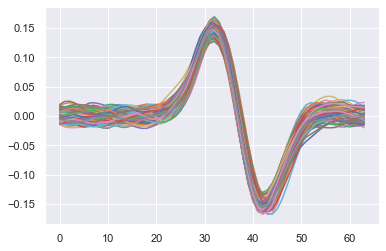

2


/var/folders/ds/ptgs391j5r77g4x8rmgcj4mh0000gp/T/ipykernel_75018/128329019.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for k in range (np.array(signals_after_corr[i]).shape[0]): #for every peak check .
/var/folders/ds/ptgs391j5r77g4x8rmgcj4mh0000gp/T/ipykernel_75018/128329019.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if np.any(np.array(signals_after_corr[i])[k]) != 0:
/var/folders/ds/ptgs391j5r77g4x8rmgcj4mh0000gp/T/ipykernel_75018/128329019.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is 

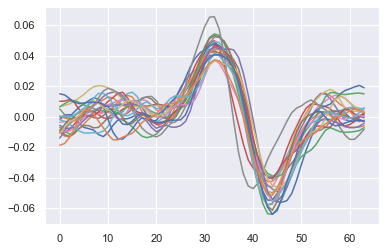

/var/folders/ds/ptgs391j5r77g4x8rmgcj4mh0000gp/T/ipykernel_75018/128329019.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for k in range (np.array(signals_after_corr[i]).shape[0]): #for every peak check .
/var/folders/ds/ptgs391j5r77g4x8rmgcj4mh0000gp/T/ipykernel_75018/128329019.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.plot(np.array(signals_after_corr[i])[k])
/var/folders/ds/ptgs391j5r77g4x8rmgcj4mh0000gp/T/ipykernel_75018/128329019.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-

3


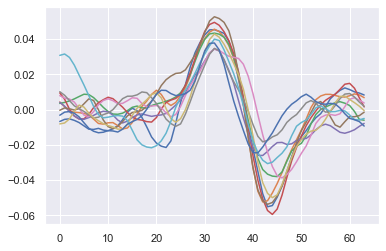

/var/folders/ds/ptgs391j5r77g4x8rmgcj4mh0000gp/T/ipykernel_75018/128329019.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for k in range (np.array(signals_after_corr[i]).shape[0]): #for every peak check .
/var/folders/ds/ptgs391j5r77g4x8rmgcj4mh0000gp/T/ipykernel_75018/128329019.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.plot(np.array(signals_after_corr[i])[k])
/var/folders/ds/ptgs391j5r77g4x8rmgcj4mh0000gp/T/ipykernel_75018/128329019.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-

4


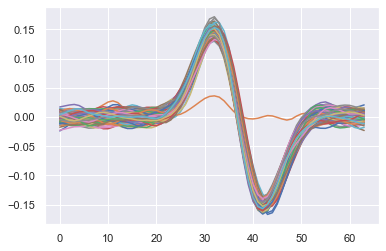

5


/var/folders/ds/ptgs391j5r77g4x8rmgcj4mh0000gp/T/ipykernel_75018/128329019.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for k in range (np.array(signals_after_corr[i]).shape[0]): #for every peak check .
/var/folders/ds/ptgs391j5r77g4x8rmgcj4mh0000gp/T/ipykernel_75018/128329019.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if np.any(np.array(signals_after_corr[i])[k]) != 0:
/var/folders/ds/ptgs391j5r77g4x8rmgcj4mh0000gp/T/ipykernel_75018/128329019.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is 

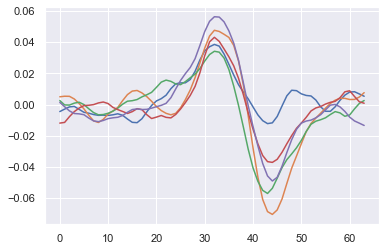

/var/folders/ds/ptgs391j5r77g4x8rmgcj4mh0000gp/T/ipykernel_75018/128329019.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for k in range (np.array(signals_after_corr[i]).shape[0]): #for every peak check .
/var/folders/ds/ptgs391j5r77g4x8rmgcj4mh0000gp/T/ipykernel_75018/128329019.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.plot(np.array(signals_after_corr[i])[k])
/var/folders/ds/ptgs391j5r77g4x8rmgcj4mh0000gp/T/ipykernel_75018/128329019.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-

/var/folders/ds/ptgs391j5r77g4x8rmgcj4mh0000gp/T/ipykernel_75018/128329019.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if np.any(np.array(signals_after_corr[i])[k]) != 0:
/var/folders/ds/ptgs391j5r77g4x8rmgcj4mh0000gp/T/ipykernel_75018/128329019.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.plot(np.array(signals_after_corr[i])[k])
/var/folders/ds/ptgs391j5r77g4x8rmgcj4mh0000gp/T/ipykernel_75018/128329019.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or 

6


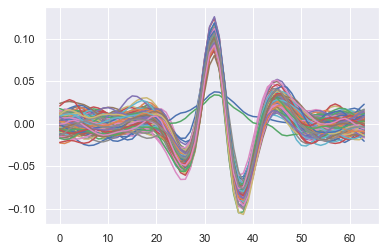

7


/var/folders/ds/ptgs391j5r77g4x8rmgcj4mh0000gp/T/ipykernel_75018/128329019.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for k in range (np.array(signals_after_corr[i]).shape[0]): #for every peak check .
/var/folders/ds/ptgs391j5r77g4x8rmgcj4mh0000gp/T/ipykernel_75018/128329019.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.plot(np.array(signals_after_corr[i])[k])
/var/folders/ds/ptgs391j5r77g4x8rmgcj4mh0000gp/T/ipykernel_75018/128329019.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-

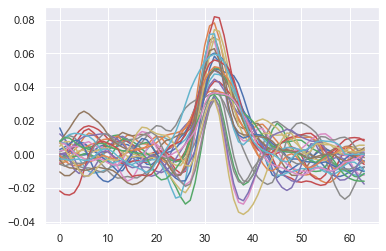

8


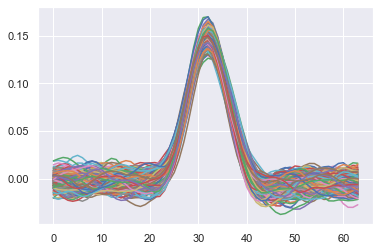

9


/var/folders/ds/ptgs391j5r77g4x8rmgcj4mh0000gp/T/ipykernel_75018/128329019.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for k in range (np.array(signals_after_corr[i]).shape[0]): #for every peak check .
/var/folders/ds/ptgs391j5r77g4x8rmgcj4mh0000gp/T/ipykernel_75018/128329019.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if np.any(np.array(signals_after_corr[i])[k]) != 0:
/var/folders/ds/ptgs391j5r77g4x8rmgcj4mh0000gp/T/ipykernel_75018/128329019.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is 

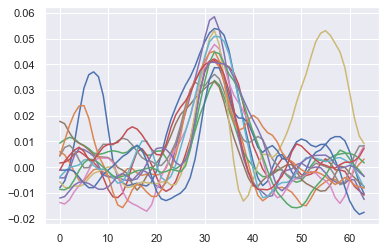

10


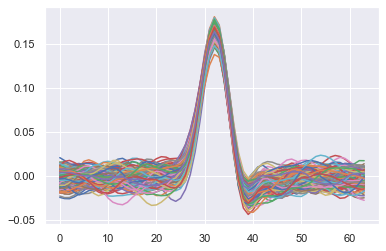

11


/var/folders/ds/ptgs391j5r77g4x8rmgcj4mh0000gp/T/ipykernel_75018/128329019.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for k in range (np.array(signals_after_corr[i]).shape[0]): #for every peak check .
/var/folders/ds/ptgs391j5r77g4x8rmgcj4mh0000gp/T/ipykernel_75018/128329019.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if np.any(np.array(signals_after_corr[i])[k]) != 0:
/var/folders/ds/ptgs391j5r77g4x8rmgcj4mh0000gp/T/ipykernel_75018/128329019.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is 

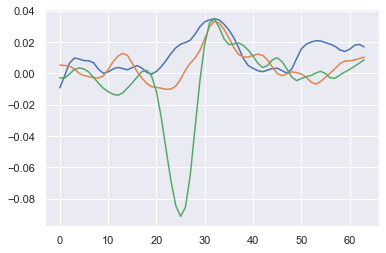

12


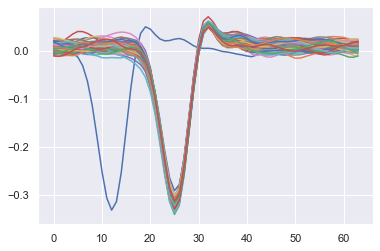

13


/var/folders/ds/ptgs391j5r77g4x8rmgcj4mh0000gp/T/ipykernel_75018/128329019.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for k in range (np.array(signals_after_corr[i]).shape[0]): #for every peak check .
/var/folders/ds/ptgs391j5r77g4x8rmgcj4mh0000gp/T/ipykernel_75018/128329019.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if np.any(np.array(signals_after_corr[i])[k]) != 0:
/var/folders/ds/ptgs391j5r77g4x8rmgcj4mh0000gp/T/ipykernel_75018/128329019.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is 

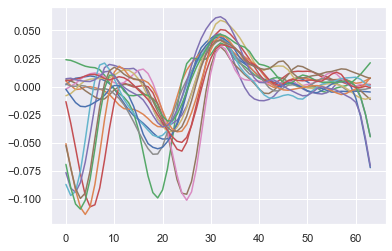

14


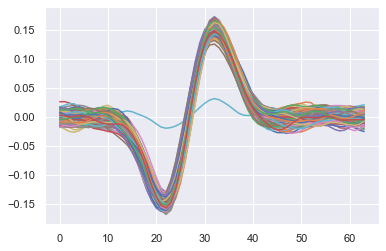

15


/var/folders/ds/ptgs391j5r77g4x8rmgcj4mh0000gp/T/ipykernel_75018/128329019.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for k in range (np.array(signals_after_corr[i]).shape[0]): #for every peak check .
/var/folders/ds/ptgs391j5r77g4x8rmgcj4mh0000gp/T/ipykernel_75018/128329019.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if np.any(np.array(signals_after_corr[i])[k]) != 0:
/var/folders/ds/ptgs391j5r77g4x8rmgcj4mh0000gp/T/ipykernel_75018/128329019.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is 

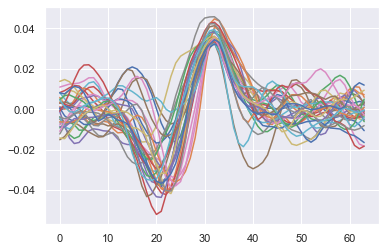

16


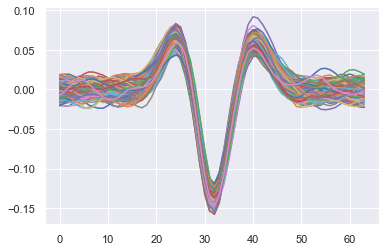

In [10]:
# calculating total number of spikes
t = 0

for i in range (16):
    for k in range (np.array(signals_after_corr[i]).shape[0]): #for every peak check .
        if np.any(np.array(signals_after_corr[i])[k]) != 0:
            plt.plot(np.array(signals_after_corr[i])[k])
            t = t+1
    print(i+1)
    plt.show()    

In [11]:
colors =['dodgerblue', 'skyblue', 'gray','deeppink','orange','saddlebrown','lawngreen', 'g','black','cyan','red','brown','lightgray','yellow','pink','magenta']
col = colors[7]

#plt.plot(np.array(cluster[3])[:,0],np.array(cluster[3])[:,1], col) 

In [12]:


for i in range(np.array(signals_after_corr).shape[0]):
    final_spikes = []
    for j in range(np.array(signals_after_corr[i]).shape[0]):
        if np.all(signals_after_corr[i][j] == 0): 
            True_sig = 1  #print(cut_ch[i][j])
        else:
            final_spikes.append(signals_after_corr[i][j])
    if final_spikes != []:        
        print(i+1) #this would be the channel number
        res = np.array(final_spikes)       
        varcovmat = np.cov(res.T)
        k = np.array(np.mean(res.T,1))
        tt = []
        for s in range(res.shape[0]):
            tt.append(k)
        varcovmat = res.T-np.array(tt).T

        u, s, v = svd(varcovmat)
        pca_data = np.dot(res,u[:,0:2])
        pca_data.shape

#         plt.scatter(pca_data[:,0],pca_data[:,1],c=colors[i])

#         #plt.xlim([-400,400])
#         #plt.ylim([-300,300])
#         plt.show()


1


/var/folders/ds/ptgs391j5r77g4x8rmgcj4mh0000gp/T/ipykernel_75018/306854623.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for i in range(np.array(signals_after_corr).shape[0]):
/var/folders/ds/ptgs391j5r77g4x8rmgcj4mh0000gp/T/ipykernel_75018/306854623.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for j in range(np.array(signals_after_corr[i]).shape[0]):


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


/var/folders/ds/ptgs391j5r77g4x8rmgcj4mh0000gp/T/ipykernel_75018/2531188957.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for j in range (np.array(signals_after_corr[i]).shape[0]):
/var/folders/ds/ptgs391j5r77g4x8rmgcj4mh0000gp/T/ipykernel_75018/2531188957.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if (np.any(np.array(signals_after_corr[i])[j]) != 0): # will measure the number of non zero elements (3d axis)
/var/folders/ds/ptgs391j5r77g4x8rmgcj4mh0000gp/T/ipykernel_75018/2531188957.py:32: VisibleDeprecationWarning: Creating an ndarra

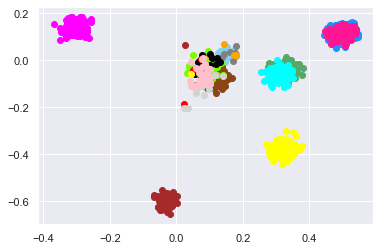

In [13]:
#now that get pca 

num = t #this is calculated in previous cell, give the number of non-zero signals    
res = np.zeros((num,T1)) # to put non-zero elements in res as arrays
chnum = np.zeros((num,1)) #this contains the channel number label for colors in plotting 

#for determining the labels and groups of clusters

clus_spike = []
clus_spike.append([])
clus_spike.append([])
clus_spike.append([])
clus_spike.append([])
clus_spike.append([])
clus_spike.append([])
clus_spike.append([])
clus_spike.append([])
clus_spike.append([])
clus_spike.append([])
clus_spike.append([])
clus_spike.append([])
clus_spike.append([])
clus_spike.append([])
clus_spike.append([])
clus_spike.append([])

p = 0
for i in range (16):
    for j in range (np.array(signals_after_corr[i]).shape[0]):
        if (np.any(np.array(signals_after_corr[i])[j]) != 0): # will measure the number of non zero elements (3d axis)
#             while p < np.array(signals_after_corr[i])[j].shape[0]:
            res[p,:] = np.array(signals_after_corr[i])[j]
            chnum[p,0] = i
            data_ch = [i] #these are the 64 signals 
            p = p+1
            if i == 0:
                clus_spike[0].append(np.array(signals_after_corr[i])[j])
            if i == 1:
                clus_spike[1].append(np.array(signals_after_corr[i])[j])
            if i == 2:
                clus_spike[2].append(np.array(signals_after_corr[i])[j])
            if i == 3:
                clus_spike[3].append(np.array(signals_after_corr[i])[j])
            if i == 4:
                clus_spike[4].append(np.array(signals_after_corr[i])[j])
            if i == 5:
                clus_spike[5].append(np.array(signals_after_corr[i])[j])
            if i == 6:
                clus_spike[6].append(np.array(signals_after_corr[i])[j])
            if i == 7:
                clus_spike[7].append(np.array(signals_after_corr[i])[j]) 
            if i == 8:
                clus_spike[8].append(np.array(signals_after_corr[i])[j])
            if i == 9:
                clus_spike[9].append(np.array(signals_after_corr[i])[j])
            if i == 10:
                clus_spike[10].append(np.array(signals_after_corr[i])[j])
            if i == 11:
                clus_spike[11].append(np.array(signals_after_corr[i])[j])
            if i == 12:
                clus_spike[12].append(np.array(signals_after_corr[i])[j])
            if i == 13:
                clus_spike[13].append(np.array(signals_after_corr[i])[j])
            if i == 14:
                clus_spike[14].append(np.array(signals_after_corr[i])[j])
            if i == 15:
                clus_spike[15].append(np.array(signals_after_corr[i])[j])
          
            
#np.save('clus_spike', clus_spike)            

varcovmat = np.cov(res.T)
k = np.array(np.mean(res.T,1))
tt = []
for i in range(res.shape[0]):
   tt.append(k)
varcovmat = res.T-np.array(tt).T

u, s, v = svd(varcovmat)
pca_data = np.dot(res,u[:,0:2])
pca_data.shape

for i in range(chnum.shape[0]):    
    plt.scatter(pca_data[i,0],pca_data[i,1], c=colors[int(chnum[i,0])])
                
#plt.xlim([-400,400])
#plt.ylim([-300,300])
plt.show()



In [14]:
# Use GEMsort to cluster the data

%matplotlib qt 

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
T_cluster = 50 # threshold for the number of spikes to be considered as a cluster

ch_num=16
for s in range(ch_num):
#     print('s=',s)
    ch_pca=[]

    for i in range(pca_data.shape[0]): 
        #print(int(chnum[i,0]))
        if s == int(chnum[i,0]):
            ch_pca.append(list(pca_data[i,:]))
    ch_pca = np.array(ch_pca)  
    if ch_pca.shape[0] > T_cluster: #if there is data
        ax.plot(ch_pca[:,0], ch_pca[:,1], s+1, linestyle="none", marker="o", markersize=3, color=colors[int(s)],zorder=1)#c=colors[int(s)],zorder=1)     
        ax.set_zlim(np.array([0,32])*0.5)
    if ch_pca.shape[0] > T_cluster:
        prenumnode = 7 
        GEMsort_dataset = ch_pca
        Nodes,GEMsort_C,GEMsort_w, nodes_total,prenumnode,d,nodess = GEMsort(prenumnode, GEMsort_dataset)
        
        for i in range(GEMsort_C.shape[0]):
            for j in range (GEMsort_C.shape[0]):
                if GEMsort_C[i,j] != -1:
                   # print i,j
                    x = [GEMsort_w[i,0],GEMsort_w[j,0]]
                    y = [GEMsort_w[i, 1], GEMsort_w[j, 1]]
                    ax.scatter(x, y, s+1, s=100, c ='r', zorder=3)
                    ax.plot(x, y, s+1,'k', zorder=2, lw=2) 

ax.set_xlabel('PC1', fontsize=15, rotation=0)
ax.set_ylabel('PC2', fontsize=15)
ax.set_zlabel('Channel Number', fontsize=15, rotation=60)

ax.set_zticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
#ax.set_xlim(left, right)
#ax.set_ylim(-0.1, 0.4)

plt.show()


/Users/zm6112/Dropbox (Princeton)/PHD_paper & material/new code_use this for postdoc analysis/website_all_codes final/Sorting_synthetic_data/GEMsort_func.py:288: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if np.array(all_nodes)[j][-1]==k:
/Users/zm6112/Dropbox (Princeton)/PHD_paper & material/new code_use this for postdoc analysis/website_all_codes final/Sorting_synthetic_data/GEMsort_func.py:289: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a=np.array(all_nodes)[j]
/Users/zm6112/Dropbox (Princeton)/PHD_paper & material/new code_use this for post